In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import torch
import torchviz
import time
import copy

import matplotlib.pyplot as plt

import ase.io

from utils.soap import compute_spherical_expansion_librascal, PowerSpectrum
from utils.gap import train_sparse_gap_model, SparseGapModel
from utils.gap import train_full_gap_model, FullGapModel
from utils.alchemical import AlchemicalCombine

torch.set_default_dtype(torch.float64)

In [2]:
frames = ase.io.read("data/elpasolites_10590.xyz", ":100")
energies = torch.tensor(np.loadtxt("data/elpasolites_10590_evpa.dat")[:100])

n_train = int(0.8 * len(frames))

train_frames = frames[:n_train]
test_frames = frames[n_train:]

train_energies = energies[:n_train]
test_energies = energies[n_train:]

In [3]:
methane_frames = ase.io.read("data/methane-100.xyz", ":")
for frame in methane_frames:
    frame.cell = [20, 20, 20]
    frame.positions[:] += 10

In [4]:
global_species = set()
for frame in frames:
    global_species.update(frame.numbers)

global_species = list(map(lambda u: int(u), global_species))

HYPERS = {
    "interaction_cutoff": 5.0,
    "max_angular": 4,
    "max_radial": 4,
    "gaussian_sigma_constant": 0.3,
    "gaussian_sigma_type": "Constant",
    "cutoff_smooth_width": 0.5,
    "radial_basis": "GTO",
    "compute_gradients": False,
    "expansion_by_species_method": "user defined",
    "global_species": global_species,
}

In [5]:
train_spherical_expansions, train_slices = compute_spherical_expansion_librascal(train_frames, HYPERS)
test_spherical_expansions, test_slices = compute_spherical_expansion_librascal(test_frames, HYPERS)

train_species = torch.hstack([torch.tensor(frame.numbers) for frame in train_frames])
test_species = torch.hstack([torch.tensor(frame.numbers) for frame in test_frames])

# Validate utilities

In [36]:
import utils.gap

def structure_sum(kernel):
    return utils.gap.SumStructureKernel.apply(kernel, test_slices, train_slices)

rand_kernel = torch.rand((len(test_slices), len(train_slices)), requires_grad=True)
torch.autograd.gradcheck(structure_sum, rand_kernel, fast_mode=True)

True

# Baseline: standard GAP model

### Sparse GAP model

In [6]:
class BasicSparseGap(torch.nn.Module):
    def __init__(self, n_support, zeta, lambdas):
        super().__init__()
        self.power_spectrum = PowerSpectrum()

        self.n_support = n_support
        self.zeta = zeta
        self.lambdas = lambdas

        self.model = None

    def fit(self, spherical_expansion, all_species, structures_slices, energies):
        power_spectrum = self.power_spectrum(spherical_expansion)

        self.model = train_sparse_gap_model(
            power_spectrum, 
            all_species,
            structures_slices,
            energies, 
            self.n_support, 
            zeta=self.zeta, 
            lambdas=self.lambdas
        )

    def forward(self, spherical_expansion, all_species, structures_slices):
        ps = self.power_spectrum(spherical_expansion)
        return self.model(ps, all_species, structures_slices)

In [7]:
def evaluate_and_plot_model(model, name, file):
    predicted_energies_training_set = model(
        train_spherical_expansions, train_species, train_slices
    )

    predicted_energies_test_set = model(
        test_spherical_expansions, test_species, test_slices
    )

    loss_fn = torch.nn.MSELoss()
    train_loss = loss_fn(predicted_energies_training_set.squeeze(), train_energies)
    test_loss = loss_fn(predicted_energies_test_set.squeeze(), test_energies)

    fig, ax = plt.subplots(1, 2, figsize=(12, 5))

    ax[0].scatter(train_energies, predicted_energies_training_set.detach().numpy())
    x = np.linspace(train_energies.min(), train_energies.max(), 20)
    ax[0].plot(x, x, color='r')

    ax[0].set_title(f'Training set — loss = {train_loss:.4}')
    ax[0].set_xlabel('DFT')
    ax[0].set_ylabel('Predicted')


    ax[1].scatter(test_energies, predicted_energies_test_set.detach().numpy())
    x = np.linspace(test_energies.min(), test_energies.max(), 20)
    ax[1].plot(x, x, color='r')

    ax[1].set_title(f'Test set — loss = {test_loss:.4}')
    ax[1].set_xlabel('DFT')
    ax[1].set_ylabel('Predicted')

    fig.suptitle(name)
    fig.savefig(file, bbox_inches="tight")

In [8]:
n_support = {
    species: 5 for species in global_species
}

In [9]:
# basic_sparse_model = BasicSparseGap(n_support, zeta=2, lambdas=[1e-6, 1e-6])
# basic_sparse_model.fit(train_spherical_expansions, train_species, train_slices, train_energies)

# evaluate_and_plot_model(
#     basic_sparse_model, 
#     f"Basic sparse model — {sum(v for v in n_support.values())} GAP support point",
#     "basic-sparse-model.pdf",
# )

In [10]:
# # plot computational graph on a smaller dataset
# small_hypers = copy.deepcopy(HYPERS)
# small_hypers["max_angular"] = 1
# small_hypers["max_radial"] = 1
# small_hypers["global_species"] = [6, 1]

# small_train_frames = methane_frames[2:]
# small_test_frames = methane_frames[:2]

# small_train_energies = torch.tensor([f.info["energy"] for f in small_train_frames])

# small_train_spherical_expansions, small_train_slices = compute_spherical_expansion_librascal(
#     small_train_frames, small_hypers
# )
# small_train_species = torch.hstack([torch.tensor(frame.numbers) for frame in small_train_frames])

# small_test_spherical_expansions, small_test_slices = compute_spherical_expansion_librascal(
#     small_test_frames, small_hypers
# )
# small_test_species = torch.hstack([torch.tensor(frame.numbers) for frame in small_test_frames])

# small_n_support = {1: 10, 6: 10}

# small_model = BasicSparseGap(small_n_support, zeta=2, lambdas=[1e-6, 1e-6])
# small_model.fit(
#     small_train_spherical_expansions, 
#     small_train_species, 
#     small_train_slices, 
#     small_train_energies
# )

# torchviz_params = {}
# for l, sph in small_test_spherical_expansions.items():
#     sph.requires_grad_(True)
#     torchviz_params[f"sph l={l}"] = sph

# for s, w in small_model.model.weights.items():
#     w.requires_grad_(True)
#     torchviz_params[f"weight species={s}"] = w

# result = small_model(small_test_spherical_expansions, small_test_species, small_test_slices)

# torchviz.make_dot(result, params=torchviz_params)

### Full model

In [11]:
class BasicFullGap(torch.nn.Module):
    def __init__(self, zeta, lambdas):
        super().__init__()
        self.power_spectrum = PowerSpectrum()

        self.zeta = zeta
        self.lambdas = lambdas

        self.model = None

    def fit(self, spherical_expansion, all_species, structures_slices, energies):
        power_spectrum = self.power_spectrum(spherical_expansion)

        self.model = train_full_gap_model(
            power_spectrum,
            all_species,
            structures_slices,
            energies, 
            zeta=self.zeta, 
            lambdas=self.lambdas
        )

    def forward(self, spherical_expansion, all_species, structures_slices):
        ps = self.power_spectrum(spherical_expansion)
        return self.model(ps, all_species, structures_slices)

In [12]:
# basic_full_model = BasicFullGap(zeta=2, lambdas=[1e-6, 1e-6])
# basic_full_model.fit(train_spherical_expansions, [], train_slices, train_energies)

# evaluate_and_plot_model(
#     basic_full_model, 
#     f"Basic full model",
#     "basic-full-model.pdf",
# )

In [13]:
# # computational graph on a smaller dataset
# small_hypers = copy.deepcopy(HYPERS)
# small_hypers["max_angular"] = 1
# small_hypers["max_radial"] = 1
# small_hypers["global_species"] = [6, 1]

# small_train_frames = methane_frames[2:]
# small_test_frames = methane_frames[:2]

# small_train_energies = torch.tensor([f.info["energy"] for f in small_train_frames])

# small_train_spherical_expansions, small_train_slices = compute_spherical_expansion_librascal(
#     small_train_frames, small_hypers
# )
# small_train_species = torch.hstack([torch.tensor(frame.numbers) for frame in small_train_frames])

# small_test_spherical_expansions, small_test_slices = compute_spherical_expansion_librascal(
#     small_test_frames, small_hypers
# )
# small_test_species = torch.hstack([torch.tensor(frame.numbers) for frame in small_test_frames])

# small_model = BasicFullGap(zeta=2, lambdas=[1e-6, 1e-6])
# small_model.fit(
#     small_train_spherical_expansions, 
#     small_train_species, 
#     small_train_slices, 
#     small_train_energies
# )

# torchviz_params = {}
# for l, sph in small_test_spherical_expansions.items():
#     sph.requires_grad_(True)
#     torchviz_params[f"sph l={l}"] = sph

# small_model.model.weights.requires_grad_(True)
# torchviz_params[f"weights"] = small_model.model.weights

# result = small_model(small_test_spherical_expansions, small_test_species, small_test_slices)

# torchviz.make_dot(result, params=torchviz_params)

# Combining species

In [14]:
class MixedSpeciesFullGap(torch.nn.Module):
    def __init__(self, species, n_pseudo_species, zeta, lambdas, optimizable_weights):
        super().__init__()
        self.power_spectrum = PowerSpectrum()
        self.alchemical = AlchemicalCombine(species, n_pseudo_species)

        self.zeta = zeta
        self.lambdas = lambdas

        self.optimizable_weights = optimizable_weights
        self.model = None

    def fit(self, spherical_expansion, all_species, structures_slices, energies):
        combined = self.alchemical(spherical_expansion)
        power_spectrum = self.power_spectrum(combined)
        
        self.model = train_full_gap_model(
            power_spectrum, 
            all_species,
            structures_slices,
            energies, 
            zeta=self.zeta, 
            lambdas=self.lambdas,
            optimizable_weights=self.optimizable_weights,
        )

    def forward(self, spherical_expansion, all_species, structures_slices):
        combined = self.alchemical(spherical_expansion)
        ps = self.power_spectrum(combined)
        return self.model(ps, all_species, structures_slices)

In [15]:
N_PSEUDO_SPECIES = 4

In [16]:
# mixed_species_model = MixedSpeciesFullGap(
#     global_species, 
#     n_pseudo_species=N_PSEUDO_SPECIES,
#     zeta=2, 
#     lambdas=[1e-6, 1e-6],
#     optimizable_weights=False,
# )
# mixed_species_model.fit(train_spherical_expansions, train_species, train_slices, train_energies)

# evaluate_and_plot_model(
#     mixed_species_model, 
#     f"Combined species, before species optimization — {sum(v for v in n_support.values())} GAP support point — {N_PSEUDO_SPECIES} pseudo species",
#     "species-before.pdf",
# )

In [17]:
# species_combining_matrix = mixed_species_model.alchemical.combining_matrix.detach().numpy()

# plt.scatter(species_combining_matrix[:, 0], species_combining_matrix[:, 1])

In [18]:
# # computational graph on a smaller dataset
# small_hypers = copy.deepcopy(HYPERS)
# small_hypers["max_angular"] = 0
# small_hypers["global_species"] = [6, 1]

# small_train_frames = methane_frames[2:4]
# small_test_frames = methane_frames[:2]

# small_train_energies = torch.tensor([f.info["energy"] for f in small_train_frames])

# small_train_spherical_expansions, small_train_slices = compute_spherical_expansion_librascal(
#     small_train_frames, small_hypers
# )
# small_train_species = torch.hstack([torch.tensor(frame.numbers) for frame in small_train_frames])

# small_test_spherical_expansions, small_test_slices = compute_spherical_expansion_librascal(
#     small_test_frames, small_hypers
# )
# small_test_species = torch.hstack([torch.tensor(frame.numbers) for frame in small_test_frames])

# torchviz_params = {}
# for l, sph in small_train_spherical_expansions.items():
#     sph.requires_grad_(True)
#     torchviz_params[f"train sph l={l}"] = sph

# small_model = MixedSpeciesFullGap(
#     species=[6, 1], 
#     n_pseudo_species=1, 
#     zeta=2, 
#     lambdas=[1e-6, 1e-6],
#     optimizable_weights=False
# )
# small_model.fit(
#     small_train_spherical_expansions, 
#     small_train_species, 
#     small_train_slices, 
#     small_train_energies
# )

# for l, sph in small_test_spherical_expansions.items():
#     sph.requires_grad_(True)
#     torchviz_params[f"test sph l={l}"] = sph


# torchviz_params["weights"] = small_model.model.weights
# torchviz_params["alchemical"] = small_model.alchemical.combining_matrix

# result = small_model(small_test_spherical_expansions, small_test_species, small_test_slices)

# torchviz_params["energies"] = result
# torchviz.make_dot(result, params=torchviz_params)

# Optimization loop for the species projection only

In [19]:
mixed_species_model = MixedSpeciesFullGap(
    global_species, 
    n_pseudo_species=N_PSEUDO_SPECIES, 
    zeta=2, 
    lambdas=[1e-6, 1e-6],
    optimizable_weights=False,
)
mixed_species_model.fit(train_spherical_expansions, train_species, train_slices, train_energies)

# there should only be 1 parameter, the species coupling
assert len(list(mixed_species_model.parameters())) == 1
optimizer = torch.optim.AdamW(mixed_species_model.parameters(), lr=0.1)

loss_fn = torch.nn.MSELoss()

for epoch in range(10):
    optimizer.zero_grad()

    mixed_species_model.fit(
        train_spherical_expansions, 
        train_species, 
        train_slices, 
        train_energies
    )
    
    predicted = mixed_species_model(
        train_spherical_expansions, train_species, train_slices
    )    

    loss = loss_fn(predicted.squeeze(), train_energies)

    if epoch % 1 == 0:
        print(epoch, loss.item())

    loss.backward()
    optimizer.step()


0 3.4709574373492416e-12
1 3.3338147430150024e-12
2 3.1967577197015e-12
3 3.06168213541181e-12
4 2.9304069857584864e-12
5 2.804542254876982e-12
6 2.6853737315421343e-12
7 2.5737801032820616e-12
8 2.470197021311648e-12
9 2.3746316423753756e-12


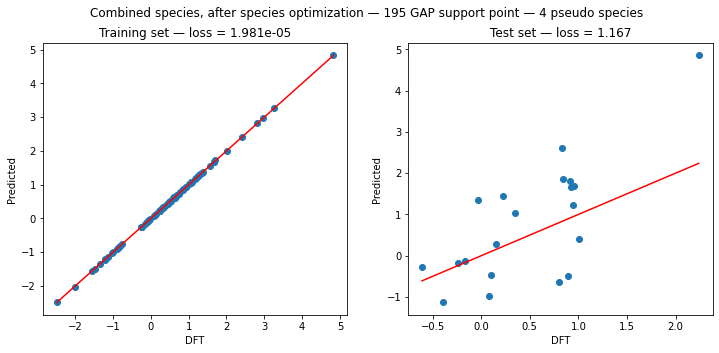

In [20]:
evaluate_and_plot_model(
    mixed_species_model, 
    f"Combined species, after species optimization — {sum(v for v in n_support.values())} GAP support point — {N_PSEUDO_SPECIES} pseudo species",
    "species-after.pdf",
)

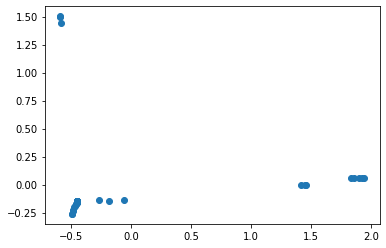

In [26]:
species_combining_matrix = mixed_species_model.alchemical.combining_matrix.detach().numpy()

plt.scatter(species_combining_matrix[:, 0], species_combining_matrix[:, 1])

# Optimization loop for both species and kernel weights

In [22]:
class AtomisticDataset(torch.utils.data.Dataset):
    def __init__(self, frames, hypers, energies):
        self.spherical_expansions = []
        for frame in frames:
            se, slices = compute_spherical_expansion_librascal([frame], hypers)
            self.spherical_expansions.append(se)
        
        self.species = [torch.tensor(frame.numbers) for frame in frames]
        self.energies = energies

    def __len__(self):
        return len(self.spherical_expansions)

    def __getitem__(self, idx):
        return self.spherical_expansions[idx], self.species[idx], self.energies[idx]

In [23]:
train_dataset = AtomisticDataset(train_frames, HYPERS, train_energies)
test_dataset = AtomisticDataset(test_frames, HYPERS, test_energies)

In [24]:
def collate_data_cpu(data):
    spherical_expansion = {
        lambda_: torch.vstack([d[0][lambda_] for d in data])
        for lambda_ in data[0][0].keys()
    }

    species = torch.hstack([d[1] for d in data])
    energies = torch.vstack([d[2] for d in data])

    slices = []
    start = 0
    for d in data:
        stop = start + d[1].shape[0]
        slices.append(slice(start, stop))
        start = stop

    return spherical_expansion, species, slices, energies

def collate_data_gpu(data):
    spherical_expansion, species, slices, energies = collate_data_cpu(data)

    spherical_expansion = {
        lambda_: se.to(device='cuda') for lambda_, se in spherical_expansion.items()
    }

    return spherical_expansion, species.to(device='cuda'), slices, energies.to(device='cuda')

### Initial training step, on CPU

In [28]:
mixed_species_model = MixedSpeciesFullGap(
    global_species, 
    n_pseudo_species=N_PSEUDO_SPECIES, 
    zeta=2, 
    lambdas=[1e-6, 1e-6],
    optimizable_weights=True,
)

cpu_dataloader = torch.utils.data.DataLoader(
    train_dataset, 
    batch_size=500, 
    collate_fn=collate_data_cpu
)
for spherical_expansions, species, slices, energies in cpu_dataloader:
    mixed_species_model.fit(spherical_expansions, species, slices, energies)

    # only use the first 500 structure to initialize the model
    break

### Optimization loop, on given device

In [32]:
# device = "cuda"
device = "cpu"

mixed_species_model.to(device=device)
# there should only be 2 parameters
assert len(list(mixed_species_model.parameters())) == 2

optimizer = torch.optim.AdamW(mixed_species_model.parameters(), lr=0.1)
# optimizer = torch.optim.LBFGS(mixed_species_model.parameters(), lr=1)

train_dataloader = torch.utils.data.DataLoader(
    train_dataset, 
    batch_size=512, 
    shuffle=True,
    collate_fn= collate_data_gpu if device == "cuda" else collate_data_cpu
)

regularizer = 1e-6

for epoch in range(20):
    epoch_start = time.time()
    for spherical_expansions, species, slices, energies in train_dataloader:
        def single_step():
            optimizer.zero_grad()
            predicted = mixed_species_model(spherical_expansions, species, slices)    

            loss = loss_fn(predicted, energies)
            # regularize the loss
            loss += regularizer * torch.linalg.norm(mixed_species_model.model.weights)
            
            loss.backward()
            return loss

        loss = optimizer.step(single_step)

    epoch_time = time.time() - epoch_start
    if epoch % 1 == 0:
        print(f"epoch {epoch} took {epoch_time:.4}s, loss={loss.item():.4}")

called


RuntimeError: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.

In [ ]:
species_combining_matrix = mixed_species_model.alchemical.combining_matrix.detach().numpy()

plt.scatter(species_combining_matrix[:, 0], species_combining_matrix[:, 1])